# EDA & 전처리

&nbsp;

## library and road data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy.special import erfc
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, VotingRegressor

from lightgbm import LGBMRegressor

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import warnings

&nbsp;

In [286]:
movies_train = pd.read_csv('movies_train.csv')
movies_test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

In [287]:
movies_train.head(3)  
#dir_prev_bfnum: 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수
#dir_prev_num: 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [288]:
movies_test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


train set: 600 obs, 12 columns, response variable: box_off_num  
test set: 243 obs, 11 columns(except of box_off_num)

&nbsp;

&nbsp;

# EDA

## 기초 통계량 확인

In [289]:
movies_train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


&nbsp;

## 상관관계 분석

In [290]:
movies_train.corr()                          #상관분석은 수치형 자료만 계산되었음

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


관객수와 다른 요인들은 대체로 양의 상관관계를 보이고 있으며 그중 배우의 수를 제외하고는 어느정도 강한 상관관계를 보임.  
특히 영화 상영시간과 스태프의 수는 강한 상관관계가 있음.

**하지만 이는 수치형 변수형만 가지고 상관관계를 분석한 것이기 때문에 다른 범주형 자료 또한 살펴볼 필요가 있음**

&nbsp;


> ### screening rat(상영등급)

In [291]:
movies_train.screening_rat.value_counts()

청소년 관람불가    204
15세 관람가     202
12세 관람가     102
전체 관람가       92
Name: screening_rat, dtype: int64

상영 등급은 등급이 높아질수록 수위가 강해진다는 의미가 있음.  
우선 범주형을 연속형으로 변환해보기로 함

In [292]:
temp_train = movies_train.copy()        # 새로운 변수 생성 위한 데이터셋 카피

In [293]:
scr_rat_num = list(np.repeat(0,len(temp_train)))
for i in range(len(temp_train)):
    if temp_train.screening_rat[i] == '전체 관람가':
        scr_rat_num[i] = 1
    elif temp_train.screening_rat[i] == '12세 관람가':
        scr_rat_num[i] = 2
    elif temp_train.screening_rat[i] == '15세 관람가':
        scr_rat_num[i] = 3
    else:
        scr_rat_num[i] = 4

In [294]:
temp_train['scr_rat_num'] = scr_rat_num                 #수치형으로 변환한 상영수위 변수

In [295]:
temp_train.scr_rat_num.value_counts()

4    204
3    202
2    102
1     92
Name: scr_rat_num, dtype: int64

**상관관계_1**

In [296]:
temp_train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,scr_rat_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,0.146784
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.029274
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.068244
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,0.127448
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,-0.033762
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.018508
scr_rat_num,0.146784,0.029274,0.068244,0.127448,-0.033762,0.018508,1.000000


약*0.0186*로 매우 낮음.  
한번 one-hot 인코딩을 통해 수치형으로 변환시켜 보기로함

In [297]:
temp_train = movies_train.copy()        # 새로운 변수 생성 위한 데이터셋 카피

In [298]:
view_all = list(np.repeat(0,len(temp_train)))                            #one-hot encoding
view_12 = list(np.repeat(0,len(temp_train)))
view_15 = list(np.repeat(0,len(temp_train)))
view_adult = list(np.repeat(0,len(temp_train)))

for i in range(len(temp_train)):
    if temp_train.screening_rat[i] == '전체 관람가':
        view_all[i] = 1
    elif temp_train.screening_rat[i] == '12세 관람가':
        view_12[i] = 1
    elif temp_train.screening_rat[i] == '15세 관람가':
        view_15[i] = 1
    else:
        view_adult[i] = 1

In [299]:
temp_train['view_all'] = view_all
temp_train['view_12'] = view_12
temp_train['view_15'] = view_15
temp_train['view_adult'] = view_adult

In [300]:
temp_train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,view_all,view_12,view_15,view_adult
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,0,0,0,1
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,0,0,0,1
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,0,0,1,0


**상관관계_2 (상영수위 원핫인코딩 버전)**

In [301]:
temp_train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,view_all,view_12,view_15,view_adult
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,-0.259244,0.017161,0.239238,-0.055087
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,-0.121613,0.079636,0.039108,-0.029173
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,-0.166861,0.020939,0.196600,-0.085814
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,-0.273736,0.060474,0.246535,-0.085689
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,0.017003,-0.018293,0.065280,-0.063550
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,-0.133525,0.033896,0.210368,-0.135180
view_all,-0.259244,-0.121613,-0.166861,-0.273736,0.017003,-0.133525,1.000000,-0.192596,-0.303177,-0.305443
view_12,0.017161,0.079636,0.020939,0.060474,-0.018293,0.033896,-0.192596,1.000000,-0.322418,-0.324828
view_15,0.239238,0.039108,0.196600,0.246535,0.065280,0.210368,-0.303177,-0.322418,1.000000,-0.511330
view_adult,-0.055087,-0.029173,-0.085814,-0.085689,-0.063550,-0.135180,-0.305443,-0.324828,-0.511330,1.000000


전체관람가는 -0.133, 12세는 0.033, 15세는 0.21, 청소년관람불가는 -0.13의 상관계수를 보인다

청소년관람불가는 언뜻 보기에 음의 방향성이 상식적으로 보이나 나머지 관람가들은 일반적인 상식으로 해석하기는 어려움

따라서 일단 상관관계가 매우 약한 12세 관람가를 제외한 view_all, view_15, view_adult 변수를 분석에 활용하기로 결정

&nbsp;

&nbsp;

> ## genre(장르)

In [302]:
movies_train.genre.value_counts()

드라마       221
다큐멘터리      93
멜로/로맨스     78
코미디        53
공포         42
액션         28
느와르        27
애니메이션      21
미스터리       17
SF         13
뮤지컬         5
서스펜스        2
Name: genre, dtype: int64

장르 변수도 마찬가지로 one-hot encoding을 통해 수치형 변수로 변환하기로 함

In [303]:
drama = list(np.repeat(0,len(temp_train)))                            #one-hot encoding
docu = list(np.repeat(0,len(temp_train)))
romance = list(np.repeat(0,len(temp_train)))
comedy = list(np.repeat(0,len(temp_train)))
horror = list(np.repeat(0,len(temp_train)))                            #one-hot encoding
action = list(np.repeat(0,len(temp_train)))
noir = list(np.repeat(0,len(temp_train)))
ani = list(np.repeat(0,len(temp_train)))
mystery = list(np.repeat(0,len(temp_train)))                            #one-hot encoding
sf = list(np.repeat(0,len(temp_train)))
musical = list(np.repeat(0,len(temp_train)))
suspense = list(np.repeat(0,len(temp_train)))


for i in range(len(temp_train)):
    if movies_train.genre[i] == '드라마':
        drama[i] = 1
    elif movies_train.genre[i] == '다큐멘터리':
        docu[i] = 1
    elif movies_train.genre[i] == '멜로/로맨스':
        romance[i] = 1
    elif movies_train.genre[i] == '코미디':
        comedy[i] = 1
    elif movies_train.genre[i] == '공포':
        horror[i] = 1
    elif movies_train.genre[i] == '액션':
        action[i] = 1
    elif movies_train.genre[i] == '느와르':
        noir[i] = 1
    elif movies_train.genre[i] == '애니메이션':
        ani[i] = 1
    elif movies_train.genre[i] == '미스터리':
        mystery[i] = 1
    elif movies_train.genre[i] == 'SF':
        sf[i] = 1
    elif movies_train.genre[i] == '뮤지컬':
        musical[i] = 1
    else :
        suspense[i] = 1
        

In [304]:
temp_train = movies_train.copy()        # 새로운 변수 생성 위한 데이터셋 카피

In [305]:
temp_train['drama'] = drama
temp_train['docu'] = docu
temp_train['romance'] = romance
temp_train['comedy'] = comedy
temp_train['horror'] = horror
temp_train['action'] = action
temp_train['noir'] = noir
temp_train['ani'] = ani
temp_train['mystery'] = mystery
temp_train['sf'] = sf
temp_train['musical'] = musical
temp_train['suspense'] = suspense

In [306]:
temp_train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,...,romance,comedy,horror,action,noir,ani,mystery,sf,musical,suspense
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,...,0,0,0,1,0,0,0,0,0,0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,...,0,0,0,0,1,0,0,0,0,0
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,...,0,0,0,1,0,0,0,0,0,0


In [307]:
temp_train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,drama,docu,romance,comedy,horror,action,noir,ani,mystery,sf,musical,suspense
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,0.159977,-0.303400,-0.090262,0.075757,-0.009848,0.166415,0.174151,-0.192651,0.016289,0.004290,0.031110,0.035617
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,-0.085041,-0.137352,0.035086,0.114415,0.004758,0.068835,0.007810,-0.034003,-0.017048,0.076652,NaN,-0.017602
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,-0.040161,-0.173434,0.036129,0.057303,0.050714,0.183462,0.077037,-0.133530,0.051792,0.054248,-0.067965,0.006032
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,0.061664,-0.344846,-0.035817,0.108996,0.041874,0.249187,0.209779,-0.122539,-0.034835,0.041529,-0.082477,-0.014017
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,-0.018618,-0.076703,-0.046865,0.131034,0.019558,-0.009006,-0.010128,0.152677,-0.057575,-0.000874,-0.033996,-0.016716
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,-0.034488,-0.150310,-0.059728,0.082780,-0.017627,0.181191,0.184869,-0.054872,-0.016888,0.088009,-0.035211,-0.019807
drama,0.159977,-0.085041,-0.040161,0.061664,-0.018618,-0.034488,1.000000,-0.327050,-0.295181,-0.237695,-0.209500,-0.168950,-0.165761,-0.145428,-0.130397,-0.113639,-0.070001,-0.044161
docu,-0.303400,-0.137352,-0.173434,-0.344846,-0.076703,-0.150310,-0.327050,1.000000,-0.165558,-0.133316,-0.117502,-0.094759,-0.092970,-0.081566,-0.073135,-0.063737,-0.039261,-0.024769
romance,-0.090262,0.035086,0.036129,-0.035817,-0.046865,-0.059728,-0.295181,-0.165558,1.000000,-0.120325,-0.106052,-0.085525,-0.083911,-0.073618,-0.066009,-0.057526,-0.035436,-0.022355
comedy,0.075757,0.114415,0.057303,0.108996,0.131034,0.082780,-0.237695,-0.133316,-0.120325,1.000000,-0.085399,-0.068869,-0.067569,-0.059281,-0.053154,-0.046323,-0.028535,-0.018001


대체로 상관관계가 없으나 다큐멘터리와 액션, 누아르 장르와는 약한 상관관계가 존재했다. 다큐멘터리는 -0.15, 액션과 누아르는 0.18이다.  
따라서 docu, action, noir 변수만 활용하기로 했다.

&nbsp;

&nbsp;

> ## distributor(배급사)

In [308]:
movies_train.distributor.value_counts()

CJ 엔터테인먼트    54
롯데엔터테인먼트     52
(주)NEW       30
(주)마운틴픽쳐스    29
(주)쇼박스       26
             ..
(주)온비즈넷       1
두 엔터테인먼트      1
싸이더스 FNH      1
(주)두타연        1
보람엔터테인먼트      1
Name: distributor, Length: 169, dtype: int64

배급사의 경우는 종류가 너무 많기 때문에 one-hot encoding을 할경우 차원이 너무 증가하게됨

따라서 배급사는 배급사의 규모나 인지도 등을 통해 구간을 나누어 새로운 파생변수를 생성해주는 방법을 고려했으나 외부데이터를 사용해도 되는지의 불확실성이 있음

일단 보류

> ## director(감독)

In [309]:
movies_train.director.value_counts()

홍상수    7
전규환    4
우민호    4
장률     4
노진수    4
      ..
김재한    1
권혁만    1
양병간    1
김병준    1
김선     1
Name: director, Length: 472, dtype: int64

In [310]:
movies_train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


감독 데이터는 dir_prev_bfnum과 dir_prev_num으로 데이터를 살릴 수 있기 때문에 따로 감독명을 변수화 시켜야 할 필요성을 못느낌

확실히 개봉 전 감독의 관객 수나 작품 수가 해당 영화의 관객 수와 양의 상관관계가 있음

&nbsp;

&nbsp;

> ## release time(개봉일)

movies 데이터는 개봉일 데이터가 있으나 시간의 흐름에 따른 영화 관객수의 변화를 살펴볼 수가 없음.  
하지만 개봉일 데이터를 활용해보기위해 개봉일에서 month(월) 데이터만 추출해서 독립변수로 활용해보기로 함

### 우선 플랏을 그려봄

In [311]:
temp_train = movies_train.copy()

temp_train.release_time = pd.to_datetime(temp_train.release_time)  # 기존의 상영일 데이터를 시계열 피처로 변환

temp_train.index = temp_train.release_time          #데이터셋의 인덱스를 시계열 데이터로 지정

temp_train_1 = temp_train.iloc[:,11]

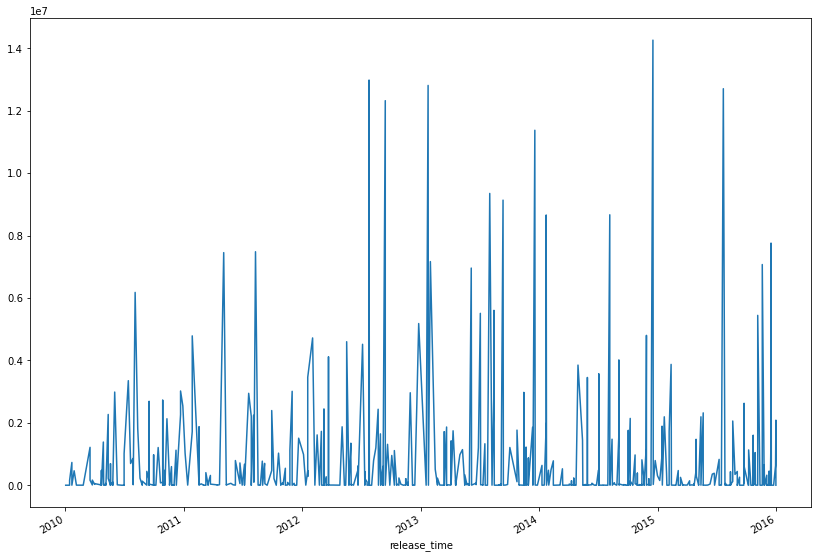

In [312]:
plt.figure(figsize=(14, 10))

temp_train_1.plot()
plt.show()

이렇게 봤을때는 어느 시즌에 관객수가 튀는지 알기 어렵고 데이터 특성상 특정 영화의 관람객이 많은 것일 수도 있음

&nbsp;

**이제 월만 추출**

In [313]:
temp_train = movies_train.copy()

temp_train.release_time = pd.to_datetime(temp_train.release_time) 

In [314]:
temp_train.release_time = temp_train.release_time.dt.month

월별 평균 관객수 계산

In [315]:
group = temp_train.box_off_num.groupby(temp_train.release_time)

<AxesSubplot:xlabel='release_time'>

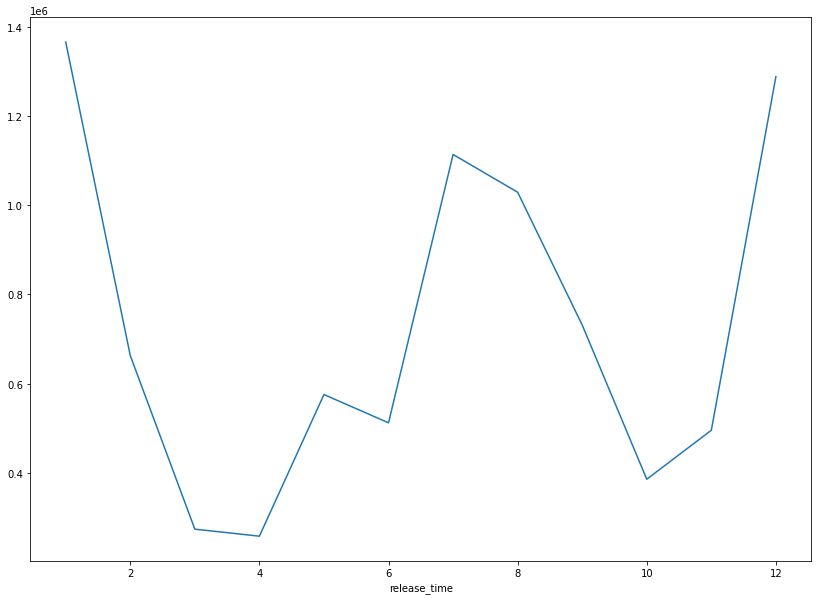

In [316]:
plt.figure(figsize=(14, 10))

group.mean().plot()

연말, 연초에 관객이 많고 7,8월 여름 시즌에 대체로 관객 수가 많음을 알 수 있다.

**따라서 새롭게 12,1,7,8월에 개봉한 데이터를 성수기 개봉 데이터로 만들어 독립변수를 활용할 예정**

In [317]:
peak_season = list(np.repeat(0,len(temp_train)))                            #one-hot encoding

for i in range(len(temp_train)):
    if temp_train.release_time[i] in (1,7,8,12)  :
        peak_season[i] = 1

In [318]:
temp_train['peak_season'] = peak_season

In [319]:
temp_train.corr()

,release_time,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,peak_season
release_time,1.000000,-0.023969,0.064117,0.034019,-0.002841,-0.015063,0.019104,0.067163
time,-0.023969,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,0.038972
dir_prev_bfnum,0.064117,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.073847
dir_prev_num,0.034019,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.023206
num_staff,-0.002841,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,0.089697
num_actor,-0.015063,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,0.057462
box_off_num,0.019104,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.179194
peak_season,0.067163,0.038972,0.073847,0.023206,0.089697,0.057462,0.179194,1.000000


*상관계수는 0.17, 나쁘지 않음*

&nbsp;

&nbsp;

&nbsp;

##  최종 데이터셋 생성

In [320]:
final_train = movies_train.copy()

#### 변수추가

In [321]:
#상영등급 데이터 추가
final_train['view_all'] = view_all                       
final_train['view_12'] = view_12
final_train['view_15'] = view_15
final_train['view_adult'] = view_adult

#장르 변수 추가
final_train['drama'] = drama
final_train['docu'] = docu
final_train['romance'] = romance
final_train['comedy'] = comedy
final_train['horror'] = horror
final_train['action'] = action
final_train['noir'] = noir
final_train['ani'] = ani
final_train['mystery'] = mystery
final_train['sf'] = sf
final_train['musical'] = musical
final_train['suspense'] = suspense


In [322]:
#개봉일 -> 개봉월로 변환
final_train.release_time = pd.to_datetime(final_train.release_time)
final_train.release_time = final_train.release_time.dt.month

&nbsp;

#### 기존 변수 제거

In [323]:
features = ['release_time', 'time','dir_prev_bfnum','dir_prev_num','num_staff',
           'num_actor','box_off_num','view_all','view_12','view_15','view_adult','drama','docu','romance','comedy',
           'horror','action','noir','ani','mystery','sf','musical','suspense']

In [324]:
final_train = final_train[features]

In [325]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   release_time    600 non-null    int64  
 1   time            600 non-null    int64  
 2   dir_prev_bfnum  270 non-null    float64
 3   dir_prev_num    600 non-null    int64  
 4   num_staff       600 non-null    int64  
 5   num_actor       600 non-null    int64  
 6   box_off_num     600 non-null    int64  
 7   view_all        600 non-null    int64  
 8   view_12         600 non-null    int64  
 9   view_15         600 non-null    int64  
 10  view_adult      600 non-null    int64  
 11  drama           600 non-null    int64  
 12  docu            600 non-null    int64  
 13  romance         600 non-null    int64  
 14  comedy          600 non-null    int64  
 15  horror          600 non-null    int64  
 16  action          600 non-null    int64  
 17  noir            600 non-null    int

&nbsp;

#### 결측값 처리

In [326]:
final_train.isna().sum()


release_time        0
time                0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
view_all            0
view_12             0
view_15             0
view_adult          0
drama               0
docu                0
romance             0
comedy              0
horror              0
action              0
noir                0
ani                 0
mystery             0
sf                  0
musical             0
suspense            0
dtype: int64

영화 제작 전 해당 감독이 참여한 영화의 평균 관객수 데이터(dir_prev_bfnum)는 결측값이 너무 많아 사용하지 않기로 했다.

In [327]:
features = ['release_time', 'time','dir_prev_num','num_staff',
           'num_actor','box_off_num','view_all','view_12','view_15','view_adult','drama','docu','romance','comedy',
           'horror','action','noir','ani','mystery','sf','musical','suspense']

final_train = final_train[features]

&nbsp;

## Min-Max scaler로 변수 스케일링

In [328]:
features_sc = ['release_time', 'time','dir_prev_num','num_staff',
           'num_actor','view_all','view_12','view_15','view_adult','drama','docu','romance','comedy',
           'horror','action','noir','ani','mystery','sf','musical','suspense']

In [329]:
final_train.loc[:,features_sc] = scaler.fit_transform(final_train.loc[:,features_sc])

In [330]:
final_train

,release_time,time,dir_prev_num,num_staff,num_actor,box_off_num,view_all,view_12,view_15,view_adult,...,romance,comedy,horror,action,noir,ani,mystery,sf,musical,suspense
0,0.909091,0.377778,0.0,0.104718,0.08,23398,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909091,0.629630,0.4,0.445339,0.12,7072501,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.454545,0.577778,0.8,0.394707,0.16,6959083,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.545455,0.414815,0.4,0.023015,0.24,217866,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.909091,0.466667,0.2,0.288838,0.08,483387,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.636364,0.488889,0.2,0.586881,0.28,1475091,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.181818,0.607407,0.2,0.329114,0.24,1716438,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.727273,0.400000,0.0,0.141542,0.16,2475,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.363636,0.422222,0.0,0.495972,0.16,2192525,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


&nbsp;

## train, vaildation data set 분할

In [331]:
X_features = ['release_time', 'time','dir_prev_num','num_staff',
           'num_actor','view_all','view_12','view_15','view_adult','drama','docu','romance','comedy',
           'horror','action','noir','ani','mystery','sf','musical','suspense']

X = final_train[X_features]
Y = final_train.box_off_num

In [332]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3,shuffle=False, random_state=seed)

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# 모델링

#### 필요 library 및 함수정의

In [182]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [184]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=5ed2d77f1bb8351cb18b0837cc4634eac222fb8a800f8dd24df17af0c8b6839a
  Stored in directory: c:\users\고태영\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=3a27e713a6375fd6facfde9009e0ada0d54ebd86012f737e5978a3c4a01bc2a9
  Stored in directory: c:\users\고태영\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termcolor wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
Note: you may need to restart the kernel to use updated packages.


In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

import keras.models
import keras.layers
import tensorflow as tf

In [172]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=2021)

In [173]:
from sklearn.metrics import make_scorer


def RMSE(pred, y):
    rmse = ( np.sum([x**2 for x in (np.array(y)-np.array(pred))]) / len(y) )**(1/2)
    return round(rmse, 4)
    
def MAE(pred, y):
    mae = np.sum([np.abs(x) for x in (np.array(y)-np.array(pred))]) / len(y)
    return round(mae, 4)


rmse_scorer = make_scorer(RMSE)
mae_scorer = make_scorer(MAE)

&nbsp;

### 랜덤포레스트

In [193]:
seed = 20163045

In [333]:
rf = RandomForestRegressor(n_estimators = 100, random_state=seed)

rmse_score = cross_val_score(rf, X, Y , cv=k_fold, scoring = rmse_scorer)
mae_score = cross_val_score(rf, X , Y, cv=k_fold, scoring = mae_scorer)

rmse_score = rmse_score.mean()
mae_score = mae_score.mean()

print('rmse: score={0:.5f}'.format(rmse_score))
print('mae: score={0:.5f}'.format(mae_score))

rmse: score=1527669.39720
mae: score=681812.36480


### lgbm

In [334]:
lgbm = LGBMRegressor(num_iterations = 200, random_state=seed)

rmse_score = cross_val_score(lgbm, X, Y , cv=k_fold, scoring = rmse_scorer)
mae_score = cross_val_score(lgbm, X , Y, cv=k_fold, scoring = mae_scorer)

rmse_score = rmse_score.mean()
mae_score = mae_score.mean()

print('rmse: score={0:.5f}'.format(rmse_score))
print('mae: score={0:.5f}'.format(mae_score))

rmse: score=1693276.75332
mae: score=803472.30784


### Keras Sequential

In [335]:
# activation function 정의: selu function

alpha_0_1 = -np.sqrt(2/np.pi) / ( erfc(1/np.sqrt(2)) * np.exp(1/2) -1 )
scale_0_1 = ( 1 - erfc(1/np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2*np.pi) * ( 2 * erfc(np.sqrt(2))*np.e**2 + 
                                                                           np.pi*erfc(1/np.sqrt(2))**2*np.e -
                                                                           2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e) +
                                                                           np.pi + 2 )**(-1/2)

def selu(z, scale = scale_0_1, alpha = alpha_0_1) :
    return scale * tf.where(z>=0.0, z, alpha*tf.nn.elu(z))

In [336]:
def build_model() :
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(30, activation=selu, input_shape=(X.shape[1],)))       #input shape 지정
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation=selu))                            #활성화 함수로 selu 함수를 사용함
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1))                                #하나의 출력값을 출력하기 위해 1개의 노드 사용
    opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01) #learning rate를 0.01로 하여 경사 하강법 최적화를 실시
    model.compile(optimizer=opt, loss='mse', metrics=['mae']) #loss함수로 mse 사용
    return model

In [187]:
from keras.wrappers.scikit_learn import KerasRegressor

In [337]:
model = KerasRegressor(build_fn=build_model, epochs=150, batch_size=10, verbose=0)   # 반복수 150으로 지정

rmse_score = cross_val_score(model, X, Y , cv=k_fold, scoring = rmse_scorer) #5-fold corss validation 실시
mae_score = cross_val_score(model, X , Y, cv=k_fold, scoring = mae_scorer)

rmse_score = rmse_score.mean()
mae_score = mae_score.mean()

print('rmse: score={0:.5f}'.format(rmse_score))
print('mae: score={0:.5f}'.format(mae_score))

rmse: score=nan
mae: score=nan


&nbsp;

> rmse 기준으로 가장 우수한 모델은 딥러닝 알고리즘인 keras sequential, mae 기준으로는 랜덤포레스트임

&nbsp;

## 성능 개선

#### 랜덤포레스트 파라미터 튜닝

In [338]:
params = {'n_estimators': [100, 200, 300, 400, 500],
              'max_depth': [2,4,6,8,10],
              'min_samples_split': [1,3,5,7,9],
              'min_samples_leaf': [1,3,5,7,9]}

model = RandomForestRegressor(random_state=seed)
    
search = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='neg_root_mean_squared_error',
                                n_iter=30, cv = 5, n_jobs = 1, random_state=seed)

X_train = X_train.to_numpy()

search.fit(X_train, Y_train)
    

model_RF = RandomForestRegressor(n_estimators=search.best_params_['n_estimators'],
                                  max_depth=search.best_params_['max_depth'],
                                  min_samples_split=search.best_params_['min_samples_split'],
                                  min_samples_leaf=search.best_params_['min_samples_leaf'],
                                  random_state=seed)
model_RF.fit(X_train ,Y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=7, min_samples_split=9,
                      random_state=20163045)

In [339]:
# valid set rmse / mae

valid_rmse_RF = RMSE(y = Y_valid, pred = model_RF.predict(X_valid))
valid_mae_RF = MAE(y = Y_valid, pred = model_RF.predict(X_valid))

valid_rmse_RF, valid_mae_RF

(1817289.8715, 819572.5452)

In [340]:
rmse_score = cross_val_score(model_RF, X, Y , cv=k_fold, scoring = rmse_scorer)
mae_score = cross_val_score(model_RF, X , Y, cv=k_fold, scoring = mae_scorer)

rmse_score = rmse_score.mean()
mae_score = mae_score.mean()

print('rmse: score={0:.5f}'.format(rmse_score))
print('mae: score={0:.5f}'.format(mae_score))

rmse: score=1483931.94366
mae: score=658595.49576


### 아주 조금 좋아졌음  
따라서 최종 모형 선정은 랜덤포레스트로 함

&nbsp;

## 최종 예측

In [341]:
movies_test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [342]:
view_all = list(np.repeat(0,len(movies_test)))                            #one-hot encoding
view_12 = list(np.repeat(0,len(movies_test)))
view_15 = list(np.repeat(0,len(movies_test)))
view_adult = list(np.repeat(0,len(movies_test)))

for i in range(len(movies_test)):
    if movies_test.screening_rat[i] == '전체 관람가':
        view_all[i] = 1
    elif movies_test.screening_rat[i] == '12세 관람가':
        view_12[i] = 1
    elif movies_test.screening_rat[i] == '15세 관람가':
        view_15[i] = 1
    else:
        view_adult[i] = 1

movies_test['view_all'] = view_all
movies_test['view_12'] = view_12
movies_test['view_15'] = view_15
movies_test['view_adult'] = view_adult

drama = list(np.repeat(0,len(movies_test)))                            #one-hot encoding
docu = list(np.repeat(0,len(movies_test)))
romance = list(np.repeat(0,len(movies_test)))
comedy = list(np.repeat(0,len(movies_test)))
horror = list(np.repeat(0,len(movies_test)))                            #one-hot encoding
action = list(np.repeat(0,len(movies_test)))
noir = list(np.repeat(0,len(movies_test)))
ani = list(np.repeat(0,len(movies_test)))
mystery = list(np.repeat(0,len(movies_test)))                            #one-hot encoding
sf = list(np.repeat(0,len(movies_test)))
musical = list(np.repeat(0,len(movies_test)))
suspense = list(np.repeat(0,len(movies_test)))


for i in range(len(movies_test)):
    if movies_test.genre[i] == '드라마':
        drama[i] = 1
    elif movies_test.genre[i] == '다큐멘터리':
        docu[i] = 1
    elif movies_test.genre[i] == '멜로/로맨스':
        romance[i] = 1
    elif movies_test.genre[i] == '코미디':
        comedy[i] = 1
    elif movies_test.genre[i] == '공포':
        horror[i] = 1
    elif movies_test.genre[i] == '액션':
        action[i] = 1
    elif movies_test.genre[i] == '느와르':
        noir[i] = 1
    elif movies_test.genre[i] == '애니메이션':
        ani[i] = 1
    elif movies_test.genre[i] == '미스터리':
        mystery[i] = 1
    elif movies_test.genre[i] == 'SF':
        sf[i] = 1
    elif movies_test.genre[i] == '뮤지컬':
        musical[i] = 1
    else :
        suspense[i] = 1
        

movies_test['drama'] = drama
movies_test['docu'] = docu
movies_test['romance'] = romance
movies_test['comedy'] = comedy
movies_test['horror'] = horror
movies_test['action'] = action
movies_test['noir'] = noir
movies_test['ani'] = ani
movies_test['mystery'] = mystery
movies_test['sf'] = sf
movies_test['musical'] = musical
movies_test['suspense'] = suspense


#개봉일 -> 개봉월로 변환
movies_test.release_time = pd.to_datetime(movies_test.release_time)
movies_test.release_time = movies_test.release_time.dt.month

features = ['release_time', 'time','dir_prev_num','num_staff',
           'num_actor','view_all','view_12','view_15','view_adult','drama','docu','romance','comedy',
           'horror','action','noir','ani','mystery','sf','musical','suspense']

movies_test = movies_test[features]

movies_test.loc[:,features] = scaler.fit_transform(movies_test.loc[:,features])

In [353]:
pred = model_RF.predict(movies_test)

data = pd.DataFrame(pred)

In [357]:
submission['box_off_num'] = data[0]

In [359]:
submission.to_csv('RandomForest.csv', index = False)